# <h1><center>MJX Tutorial  <a href="https://colab.research.google.com/github/patsyuk03/MJX_Tutorial/blob/main/MJX_Tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

In [ ]:
#@title Install MuJoCo and MJX
!pip install mujoco
!pip install mujoco_mjx

In [ ]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [ ]:
#@title Import packages for plotting and creating graphics
import time
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

In [ ]:
#@title Clone GitHub repository with MJX Tutorial
import os
!git clone https://github.com/patsyuk03/MJX_Tutorial.git
os.chdir('MJX_Tutorial')

In [ ]:
#@title Other Imports

import mujoco
import mujoco.mjx as mjx
import jax
import jax.numpy as jnp
from functools import partial

# import mujoco
# import mujoco.mjx as mjx
# import jax
# import jax.numpy as jnp
# from functools import partial
# import os
# import time
# import numpy as np
# import mediapy as media
# import matplotlib.pyplot as plt

In [2]:
num_dof = 6
num_batch = 100
num_steps = 50
timestep = 0.05

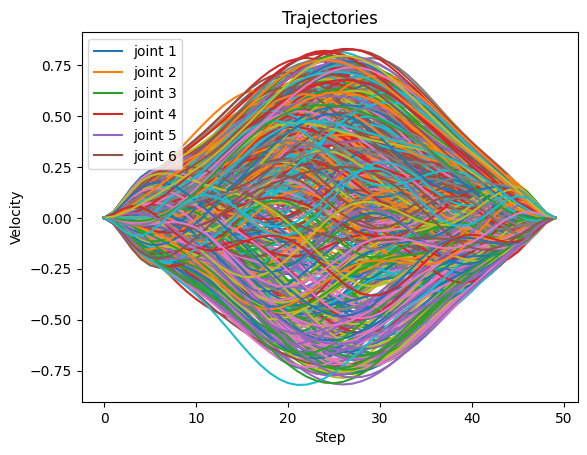

In [3]:
#@title Import Generated Samples

trajectories_file_path = f"{os.getcwd()}/samples/trajectories.csv"
trajectories = np.genfromtxt(trajectories_file_path, delimiter=',')
for traj in trajectories:
    plt.plot(traj.reshape(num_dof, num_steps).T)
plt.title("Trajectories")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')

plt.show()

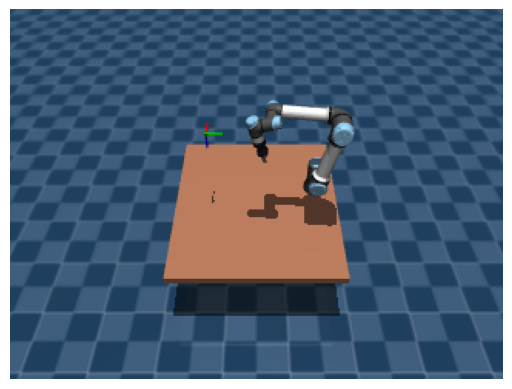

In [4]:
#@title Initialize Mujoco Model, Data and Renderer

model_path = f"{os.getcwd()}/ur5e_hande_mjx/scene.xml"
model = mujoco.MjModel.from_xml_path(model_path)
model.opt.timestep = timestep

data = mujoco.MjData(model)
data.qpos[:6] = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0])

mujoco.mj_forward(model, data)
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
camera.lookat[:] = [0.0, 0.0, 0.5]
camera.distance = 3.0

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = False
scene_option.sitegroup[1] = True

renderer.update_scene(data, scene_option=scene_option, camera=camera)
pixels = renderer.render()

plt.imshow(pixels)
plt.axis('off')
plt.show()

In [5]:
#@title Simulator

class Simulator():
	def __init__(self, model, data, num_dof=6, num_batch=100, num_steps=200):
		super(Simulator, self).__init__()

		self.num_dof = num_dof
		self.num_batch = num_batch
		self.num = num_steps

		self.target_pos = model.body(name="target").pos
		self.target_rot = model.body(name="target").quat

		self.hande_id = model.body(name="hande").id
		self.tcp_id = model.site(name="tcp").id

		self.mjx_model = mjx.put_model(model)
		self.mjx_data = mjx.put_data(model, data)
		self.jit_step = jax.jit(mjx.step)

		self.compute_rollout_batch = jax.vmap(self.compute_rollout_single, in_axes = (0))
		self.compute_cost_batch = jax.vmap(self.compute_cost_single, in_axes = (0))

	@partial(jax.jit, static_argnums=(0,))
	def compute_cost_single(self, eef_pos, eef_rot):
		cost_g = jnp.linalg.norm(eef_pos - self.target_pos)

		dot_product = jnp.abs(jnp.dot(eef_rot/jnp.linalg.norm(eef_rot, axis=1).reshape(1, self.num).T, self.target_rot/jnp.linalg.norm(self.target_rot)))
		dot_product = jnp.clip(dot_product, -1.0, 1.0)
		cost_r_ = 2 * jnp.arccos(dot_product)
		cost_r = jnp.sum(cost_r_)

		cost = 1*cost_g + 0.2*cost_r
		return cost

	@partial(jax.jit, static_argnums=(0,))
	def mjx_step(self, mjx_data, thetadot_single):
		qvel = mjx_data.qvel.at[:self.num_dof].set(thetadot_single)
		mjx_data = mjx_data.replace(qvel=qvel)
		mjx_data = self.jit_step(self.mjx_model, mjx_data)

		theta = mjx_data.qpos[:self.num_dof]
		eef_rot = mjx_data.xquat[self.hande_id]
		eef_pos = mjx_data.site_xpos[self.tcp_id]

		return mjx_data, (theta, eef_pos, eef_rot)

	@partial(jax.jit, static_argnums=(0,))
	def compute_rollout_single(self, thetadot):
		mjx_data = self.mjx_data
		thetadot_single = thetadot.reshape(self.num_dof, self.num)
		_, out = jax.lax.scan(self.mjx_step, mjx_data, thetadot_single.T, length=self.num)
		theta, eef_pos, eef_rot= out
		return theta.T.flatten(), eef_pos, eef_rot

	@partial(jax.jit, static_argnums=(0,))
	def get_best_traj(self, thetadot):
		theta, eef_pos, eef_rot = self.compute_rollout_batch(thetadot)
		cost_batch = self.compute_cost_batch(eef_pos, eef_rot)

		idx_min = jnp.argmin(cost_batch)
		cost = jnp.min(cost_batch)
		best_traj = thetadot[idx_min].reshape((self.num_dof, self.num)).T
		return cost, best_traj

sim = Simulator(model=model, data=data, num_batch=num_batch, num_dof=num_dof, num_steps=num_steps)

Trajectory Cost: 4.773920059204102


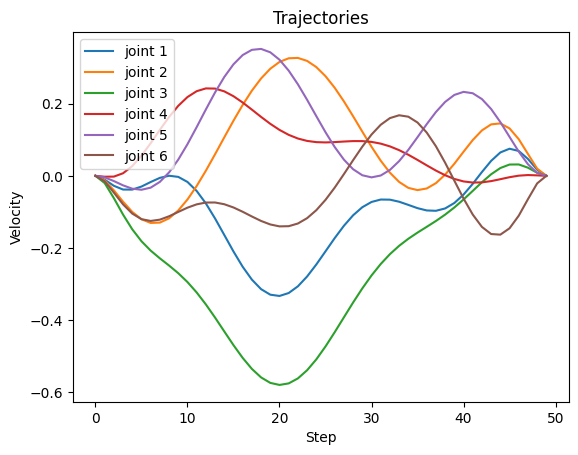

In [6]:
cost, best_traj = sim.get_best_traj(trajectories)

print(f"Trajectory Cost: {cost}")
plt.plot(best_traj)
plt.title("Trajectories")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

In [7]:
framerate = 30
frames = list()
for step in best_traj:
    step_start = time.time()
    data.qvel[:6] = step

    mujoco.mj_step(model, data)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera=camera)
        pixels = renderer.render()
        frames.append(pixels)

    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
        time.sleep(time_until_next_step)

In [8]:
media.show_video(frames, fps=framerate)